In [ ]:
import torch
import math

from transformers import GPT2Tokenizer, GPT2LMHeadModel, set_seed, AutoModel, AutoConfig, GPT2Model
from datasets import load_dataset

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from transformers import BatchEncoding
from torch.nn.functional import softmax

from minicons import scorer
from torch.utils.data import DataLoader
from torch.nn.functional import gumbel_softmax

import json
from datasets import load_dataset, load_from_disk
import os
from tqdm import tqdm

from modular_transformers.straightening.straightening_utils import compute_model_activations, compute_model_curvature
from modular_transformers.models.gpt2.configuration_gpt2 import GPT2Config
from transformer_xray.record_utils import ActivationRecorder
from modular_transformers.models import components

from functools import partial

# import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, FactoredMatrix
torch.set_grad_enabled(False)

#set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#set tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

path = "/om2/user/jackking/modular_transformers/scripts/adding_straightness"

In [40]:
import torch
from transformers import GPT2Tokenizer, GPT2Model
from torch.nn.functional import softmax
from torch.optim import Adam
import matplotlib.pyplot as plt
import math 

In [41]:
def compute_layer_curvature(activations):
    sent_act = torch.diff(activations).squeeze()
    
    # Initialize curve without in-place modification
    curve_values = []
    for idx in range(len(sent_act) - 1):
        dot_product = torch.dot(sent_act[idx, :], sent_act[idx + 1, :])
        # Normalize dot product to be within the range [-1, 1] to avoid domain errors with arccos
        dot_product = dot_product / (torch.norm(sent_act[idx, :]) * torch.norm(sent_act[idx + 1, :]))
        dot_product = torch.clamp(dot_product, -1, 1)
        curve_values.append(dot_product)

    #put curve into backprop graph
    curve = torch.stack(curve_values)
    curvature = torch.arccos(curve).mean()
    return curvature

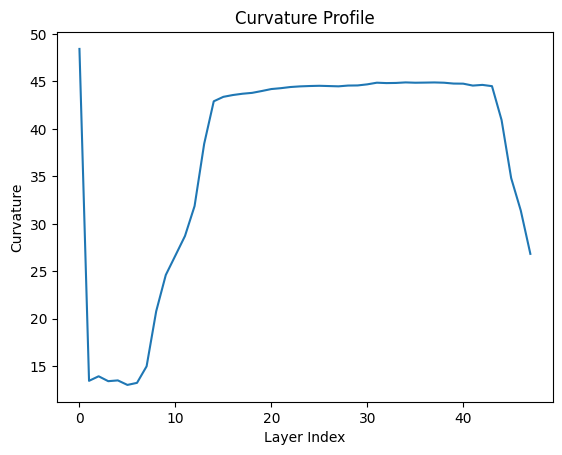

Step 0: Curvature = 2.3703243732452393
Step 50: Curvature = 1.516729474067688
Step 100: Curvature = 1.2463419437408447
Step 150: Curvature = 0.8277781009674072
Step 200: Curvature = 0.7893807888031006
Step 250: Curvature = 0.7851216793060303
Step 300: Curvature = 0.7287774085998535
Step 350: Curvature = 0.7150187492370605
Step 400: Curvature = 0.703275203704834
Step 450: Curvature = 0.69429612159729


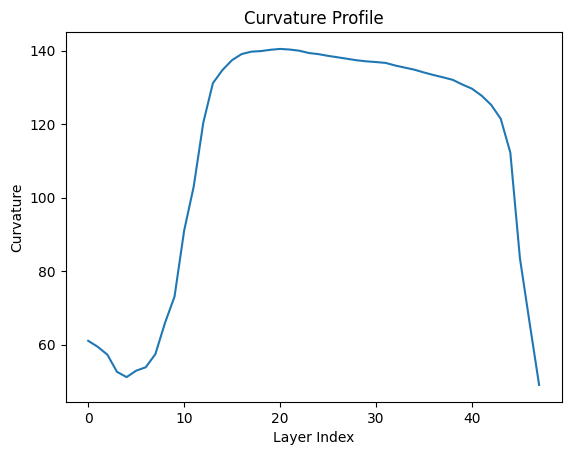

Generated Sequence:  cohol row avoided distrations^^dropping overpower contemplatingliam


In [45]:
# Load tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2-xl')
model.eval()  # Switch to evaluation mode if not training other components

# Configure device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize soft tokens
num_tokens = 10  # Length of the sequence to generate
soft_tokens = torch.randn((1, num_tokens, tokenizer.vocab_size), device=device, requires_grad=True)

# Optimizer for soft tokens
optimizer = Adam([soft_tokens], lr=0.1)

# Example target neuron configuration
layer_index = 20  # Choose a specific transformer layer

def run():
    # Softmax to create a probability distribution over the vocabulary
    probs = softmax(soft_tokens, dim=-1)
    # Calculate the weighted sum of embeddings according to the soft token distribution
    wte = model.get_input_embeddings().weight
    inputs = torch.matmul(probs, wte)

    # Feed the 'soft' embeddings to the model
    outputs = model(inputs_embeds = inputs, output_hidden_states=True, output_attentions=False)
    # Extract the activation from the specified neuron
    activation = outputs.hidden_states[layer_index]
    curvature = compute_layer_curvature(activation) 

    return curvature

def plot_curvature():
    probs = softmax(soft_tokens, dim=-1)
    wte = model.get_input_embeddings().weight
    inputs = torch.matmul(probs, wte)
    outputs = model(inputs_embeds = inputs, output_hidden_states=True, output_attentions=False)
    curve = []
    for layer_index in range(model.config.n_layer):
        activation = outputs.hidden_states[layer_index]
        curvature = compute_layer_curvature(activation).cpu().item() / math.pi * 180
        curve.append(curvature)

    plt.plot(curve)
    plt.xlabel("Layer Index")
    plt.ylabel("Curvature")
    plt.title("Curvature Profile")
    plt.show()

plot_curvature()

increase_curvature = True

# Optimization loop
for step in range(500): # Number of optimization steps
    optimizer.zero_grad() # Clear previous gradients
    curvature = run() # Compute curvature (negative for maximization)
    if increase_curvature:
        curvature = math.pi - curvature
    curvature.backward() # Compute gradients
    optimizer.step() # Update parameters based on gradients
    
    if step % 50 == 0:
        print(f"Step {step}: Curvature = {curvature.item()}")

plot_curvature()


# Decode the final optimized soft tokens
with torch.no_grad():
    final_probs = softmax(soft_tokens, dim=-1)
    _, top_tokens = final_probs.topk(1, dim=-1)
    generated_sequence = tokenizer.decode(top_tokens.squeeze().tolist())

print("Generated Sequence: ", generated_sequence)


In [52]:
def sample_soft_tokens(soft_tokens, num_samples=1):
    # Apply softmax to convert logits to probabilities
    probs = softmax(soft_tokens, dim=-1)
    
    # Sample from these probabilities
    sampled_indices = torch.multinomial(probs, num_samples, replacement=True)
    
    return sampled_indices

# Example usage:
# Assuming soft_tokens is a 1 x num_tokens x vocab_size tensor
sampled_tokens = sample_soft_tokens(soft_tokens.squeeze())
generated_sequence = tokenizer.decode(sampled_tokens.squeeze().tolist())
print("Generated Sequence: ", generated_sequence)

Generated Sequence:   Prev personalized lacked distailsPicdevDoutermin Pow


In [ ]:
lowest_curve_tokens = soft_tokens